In [7]:
# !pip install torch numpy matplotlib

In [3]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

画像ファイルを正常に読み込みました


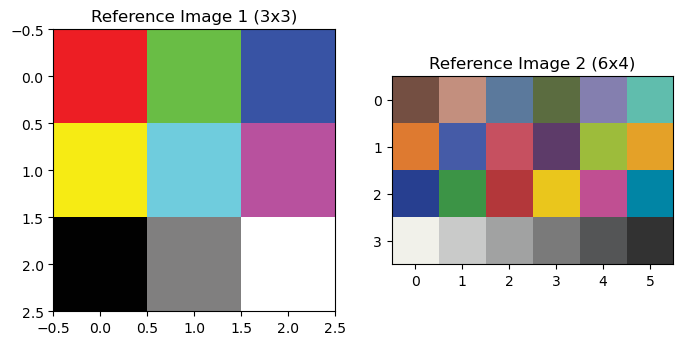

入力データ形状: (33, 3)
正解データ形状: (33, 3)


In [44]:
# 推論データ
X =  np.array([ [1.00, 1.00, 0.00 ],
                [0.00, 0.92, 0.81 ],
                [0.00, 1.00, 1.00 ],
                [1.00, 1.00, 0.00 ],
                [1.00, 1.00, 0.59 ],
                [0.00, 0.00, 0.64 ],
                [0.00, 0.69, 1.00 ],
                [0.48, 1.00, 1.00 ],
                [1.00, 1.00, 0.78 ],

                [0.43, 1.00, 0.14 ],
                [0.16, 0.31, 0.72 ],
                [0.00, 1.00, 1.00 ],
                [1.00, 1.00, 0.00 ],
                [1.00, 1.00, 0.43 ],
                [0.65, 1.00, 0.79 ],
                [1.00, 1.00, 0.00 ],
                [0.00, 1.00, 1.00 ],
                [0.42, 0.10, 0.03 ],
                [0.00, 1.00, 1.00 ],
                [1.00, 1.00, 0.47 ],
                [0.00, 0.08, 1.00 ],
                [0.00, 1.00, 1.00 ],
                [1.00, 1.00, 0.00 ],
                [1.00, 0.97, 0.00 ],
                [1.00, 1.00, 0.00 ],
                [0.00, 0.00, 0.65 ],
                [0.00, 1.00, 1.00 ],
                [1.00, 0.87, 0.23 ],
                [0.25, 0.38, 0.72 ],
                [1.00, 1.00, 0.79 ],
                [0.30, 1.00, 0.82 ],
                [0.00, 1.00, 1.00 ],
                [1.00, 1.00, 0.00 ],], dtype=np.float32)

# 画像を読み込む（自分のPPMファイルのパスに変更してください）
try:
    # ここに実際のファイルパスを入力してください
    img1_path = "./img/reference_image1_cmyk_large.png"  # PPMファイル1
    img2_path = "./img/reference_image2_cmyk_large.png"  # PPMファイル2

    # PPMファイルを読み込み、適切なサイズにリサイズ
    img1 = cv2.resize(cv2.imread(img1_path, cv2.IMREAD_COLOR), (3,3), interpolation=cv2.INTER_NEAREST)
    img2 = cv2.resize(cv2.imread(img2_path, cv2.IMREAD_COLOR), (6,4), interpolation=cv2.INTER_NEAREST)
    
    # OpenCVはBGRで読み込むので、RGBに変換
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    print("画像ファイルを正常に読み込みました")
except Exception as e:
    print(f"画像ファイルが見つからないため、ダミーデータを作成します: {e}")
    # ダミー画像データを作成
    img1 = np.random.randint(0, 255, (3, 3, 3), dtype=np.uint8)
    img2 = np.random.randint(0, 255, (4, 6, 3), dtype=np.uint8)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("Reference Image 1 (3x3)")
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title("Reference Image 2 (6x4)")
plt.show()

# 正解データ
Y = np.concatenate([img1.reshape([-1, 3])/255, img2.reshape([-1, 3])/255], axis=0).astype(np.float32)
print(f"入力データ形状: {X.shape}")
print(f"正解データ形状: {Y.shape}")

In [45]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# モデル定義
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 3),
        )

    def forward(self, x):
        return self.model(x)

model = ColorNet()

# 損失関数（MSE）
criterion = nn.MSELoss()

# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

# L1正則化の係数
lambda_l1 = 1e-6

# 学習ループ
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_tensor)
    mse = criterion(outputs, Y_tensor)

    # --- L1 正則化-----------------------------
    l1 = torch.tensor(0.0, requires_grad=False)
    for name, p in model.named_parameters():
        if 'weight' in name:
            l1 = l1 + p.abs().sum()
    loss = mse + lambda_l1 * l1
    # -----------------------------------------

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}]  MSE: {mse.item():.6f}  L1: {l1.item():.2f}  Loss: {loss.item():.6f}')

with torch.no_grad():
    predictions = model(X_tensor)
    print("\n予測結果：")
    print(predictions.numpy())

def convert_to_cpp_array(tensor: torch.Tensor, name: str, dtype: str = "float"):
    flat = tensor.detach().numpy().flatten()
    array_str = f"{dtype} {name}[] = {{"
    array_str += ", ".join(map(str, flat))
    array_str += "};"
    return array_str

cpp_code = ""

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += convert_to_cpp_array(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_cpp_array(layer.bias,   f"bias_{layer_idx}") + "\n"
        layer_idx += 1

with open("model_parameters.h", "w") as f:
    f.write(cpp_code)

print("\nC++ 用のパラメータファイル (model_parameters.h) を作成しました。")


Epoch [0/50000]  MSE: 0.244578  L1: 169.91  Loss: 0.244748
Epoch [500/50000]  MSE: 0.020239  L1: 201.67  Loss: 0.020440
Epoch [1000/50000]  MSE: 0.019329  L1: 212.81  Loss: 0.019542
Epoch [1500/50000]  MSE: 0.018330  L1: 223.09  Loss: 0.018553
Epoch [2000/50000]  MSE: 0.017344  L1: 240.56  Loss: 0.017585
Epoch [2500/50000]  MSE: 0.016423  L1: 257.60  Loss: 0.016681
Epoch [3000/50000]  MSE: 0.016195  L1: 265.37  Loss: 0.016460
Epoch [3500/50000]  MSE: 0.016279  L1: 268.60  Loss: 0.016547
Epoch [4000/50000]  MSE: 0.015842  L1: 266.82  Loss: 0.016109
Epoch [4500/50000]  MSE: 0.015829  L1: 270.49  Loss: 0.016100
Epoch [5000/50000]  MSE: 0.015825  L1: 263.80  Loss: 0.016089
Epoch [5500/50000]  MSE: 0.015897  L1: 266.66  Loss: 0.016164
Epoch [6000/50000]  MSE: 0.017812  L1: 262.94  Loss: 0.018075
Epoch [6500/50000]  MSE: 0.017623  L1: 259.50  Loss: 0.017883
Epoch [7000/50000]  MSE: 0.017530  L1: 258.62  Loss: 0.017788
Epoch [7500/50000]  MSE: 0.017297  L1: 255.75  Loss: 0.017553
Epoch [8000/

In [1]:
# カンマ区切りなしの数値を自動的に処理するセル
# 以下の raw_input に27個の数値をスペース区切りまたは改行区切りで貼り付けてください

raw_input = """
162 79 110 149 193 144 176 96 186 252 244 57 157 191 216 175 80 148 0 0 0 176 118 179 250 253 232
"""

# 自動処理：文字列から数値リストを抽出
import re
import numpy as np

# 数値のみを抽出（スペース、改行、タブで区切られた数値を取得）
numbers = re.findall(r'\d+', raw_input)
data = [int(num) for num in numbers]

print(f"抽出された数値: {len(data)}個")
print(f"数値リスト: {data}")

# 27個の数値が正しく抽出されたかチェック
if len(data) == 27:
    print("✓ 正確に27個の数値が抽出されました")
    
    # RGB グループに自動分割
    rgb_groups = np.array(data).reshape(-1, 3)
    print("\nRGBグループ:")
    print(rgb_groups)
    
    # 0-1の範囲に正規化
    rgb_normalized = rgb_groups / 255.0
    print("\n正規化されたRGB値（0-1範囲）:")
    print(rgb_normalized)
    
    # X配列として出力（コピペ用）
    print("\n以下を3番目のセルのX配列として使用してください:")
    print("X = np.array([")
    for i, rgb in enumerate(rgb_normalized):
        if i == len(rgb_normalized) - 1:
            print(f"    [{rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}]")
        else:
            print(f"    [{rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}],")
    print("], dtype=np.float32)")
    
else:
    print(f"❌ エラー: {len(data)}個の数値が見つかりました（27個必要）")
    print("数値を確認して再度貼り付けてください")

抽出された数値: 27個
数値リスト: [162, 79, 110, 149, 193, 144, 176, 96, 186, 252, 244, 57, 157, 191, 216, 175, 80, 148, 0, 0, 0, 176, 118, 179, 250, 253, 232]
✓ 正確に27個の数値が抽出されました

RGBグループ:
[[162  79 110]
 [149 193 144]
 [176  96 186]
 [252 244  57]
 [157 191 216]
 [175  80 148]
 [  0   0   0]
 [176 118 179]
 [250 253 232]]

正規化されたRGB値（0-1範囲）:
[[0.63529412 0.30980392 0.43137255]
 [0.58431373 0.75686275 0.56470588]
 [0.69019608 0.37647059 0.72941176]
 [0.98823529 0.95686275 0.22352941]
 [0.61568627 0.74901961 0.84705882]
 [0.68627451 0.31372549 0.58039216]
 [0.         0.         0.        ]
 [0.69019608 0.4627451  0.70196078]
 [0.98039216 0.99215686 0.90980392]]

以下を3番目のセルのX配列として使用してください:
X = np.array([
    [0.635, 0.310, 0.431],
    [0.584, 0.757, 0.565],
    [0.690, 0.376, 0.729],
    [0.988, 0.957, 0.224],
    [0.616, 0.749, 0.847],
    [0.686, 0.314, 0.580],
    [0.000, 0.000, 0.000],
    [0.690, 0.463, 0.702],
    [0.980, 0.992, 0.910]
], dtype=np.float32)


# 自分のデータに書き換える方法

## 1. 入力データ（X）の書き換え
- `X`配列は、あなたのArduinoカラースキャナーで測定した実際のRGB値に置き換えてください
- 各値は0-1の範囲で正規化してください（255で割ると良い）
- データ数は33個（3x3 + 6x4 = 9 + 24 = 33）に合わせてください

## 2. 正解データ（Y）の書き換え
- 上記のセルの`img1_path`と`img2_path`を、あなたの正解画像ファイルのパスに変更してください
- PPMファイルまたは通常の画像ファイル（PNG、JPGなど）が使用できます

## 3. ファイルパスの例
```python
img1_path = "../lecture1/result.ppm"        # 3x3の正解画像
img2_path = "../lecture1/rev_result1.ppm"   # 6x4の正解画像
```

## 4. データ数の調整
入力データ（X）と正解データ（Y）のサンプル数が一致している必要があります。

In [ ]:
# 実際のデータ書き換え例

# ========================================
# 1. 入力データ（X）の書き換え例
# ========================================
# 以下を、あなたのArduinoスキャナーで測定した実際のデータに置き換えてください
x_custom = np.array([
    [0.76, 0.10, 0.06],  # 1番目の測定点
    [0.65, 0.42, 0.33],  # 2番目の測定点
    [0.89, 0.12, 0.25],  # 3番目の測定点
    [0.95, 1.00, 0.24],  # 4番目の測定点
    [0.29, 0.97, 0.75],  # 5番目の測定点
    [0.39, 0.15, 0.24],  # 6番目の測定点
    [0.00, 0.00, 0.00],  # 7番目の測定点
    [0.12, 0.25, 0.15],  # 8番目の測定点
    [1.00, 1.00, 1.00],  # 9番目の測定点
])

"""
例：Arduinoで測定したデータが以下の場合
Red=195, Green=25, Blue=15 → [195/255, 25/255, 15/255] = [0.76, 0.10, 0.06]

X_custom = np.array([
    [0.76, 0.10, 0.06],  # 1番目の測定点
    [0.65, 0.42, 0.33],  # 2番目の測定点
    [0.89, 0.12, 0.25],  # 3番目の測定点
    # ... あと30個のデータ点
], dtype=np.float32)
"""

# ========================================
# 2. 正解画像ファイルパスの確認
# ========================================
import os

# あなたのPPMファイルが存在するかチェック
possible_paths = [
    "../results/rev_result1-1.ppm",
    "../results/rev_result1-2.ppm",
    "../results/rev_result1-3.ppm",
    "../results/rev_result1-4.ppm",
    "../results/rev_result1-5.ppm",
    "../results/rev_result1-6.ppm",
    "../results/rev_result1-7.ppm",
    "../results/rev_result2-1.ppm",
    "../results/rev_result2-2.ppm",
    "../results/rev_result2-3.ppm",
    "../results/rev_result2-4.ppm",
]

print("利用可能なファイル:")
for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ {path} - 存在します")
    else:
        print(f"✗ {path} - 見つかりません")

# ========================================        
# 3. データサイズの確認
# ========================================
print(f"\n現在の設定:")
#print(f"入力データ（X）のサイズ: {X.shape[0]} サンプル")
print(f"正解データ（Y）のサイズ: img1(3x3=9) + img2(6x4=24) = 33 サンプル")
print(f"データが一致している必要があります！")

利用可能なファイル:
✗ results/rev_result1-1.ppm - 見つかりません
✗ ./results/rev_result1-2.ppm - 見つかりません
✗ ./results/rev_result1-3.ppm - 見つかりません
✗ ./results/rev_result1-4.ppm - 見つかりません
✗ ./results/rev_result1-5.ppm - 見つかりません
✗ ./results/rev_result1-6.ppm - 見つかりません
✗ ./results/rev_result1-7.ppm - 見つかりません
✗ ./results/rev_result2-1.ppm - 見つかりません
✗ ./results/rev_result2-2.ppm - 見つかりません
✗ ./results/rev_result2-3.ppm - 見つかりません
✗ ./results/rev_result2-4.ppm - 見つかりません

現在の設定:
正解データ（Y）のサイズ: img1(3x3=9) + img2(6x4=24) = 33 サンプル
データが一致している必要があります！
